In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['sample_submission_ns2btKE.csv', 'train', 'test_ApKoW4T.csv']


In [2]:
train = pd.read_csv('../input/train/train.csv')
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
from fastai import *

In [4]:
from fastai.vision import *
from fastai.basics import *

In [5]:
ls '../input/'

sample_submission_ns2btKE.csv  test_ApKoW4T.csv  train/


In [6]:
path= Path('../input/train/')

In [7]:
'../input/train/'

'../input/train/'

In [8]:
tfms=get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, res

In [9]:
data = (ImageList .from_csv(path, folder='images', csv_name='train.csv', cols='image')
       #.use_partial_data(sample_pct = .1, seed= 34)
       .split_by_rand_pct(valid_pct=0.1, seed=34)
       .label_from_df(cols='category')
        .add_test_folder(Path('../input/test_ApKoW4T.csv'))
       .transform(tfms, size = 224)
       .databunch(bs=32)).normalize(imagenet_stats)

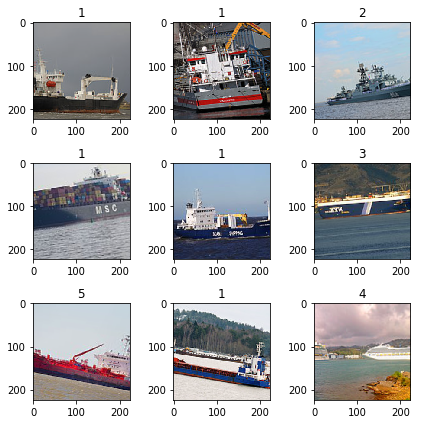

In [10]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [12]:
### BAM


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class ChannelGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, num_layers=1):
        super(ChannelGate, self).__init__()
        self.gate_activation = gate_activation
        self.gate_c = nn.Sequential()
        self.gate_c.add_module( 'flatten', Flatten() )
        gate_channels = [gate_channel]
        gate_channels += [gate_channel // reduction_ratio] * num_layers
        gate_channels += [gate_channel]
        for i in range( len(gate_channels) - 2 ):
            self.gate_c.add_module( 'gate_c_fc_%d'%i, nn.Linear(gate_channels[i], gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_bn_%d'%(i+1), nn.BatchNorm1d(gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_relu_%d'%(i+1), nn.ReLU() )
        self.gate_c.add_module( 'gate_c_fc_final', nn.Linear(gate_channels[-2], gate_channels[-1]) )
    def forward(self, in_tensor):
        avg_pool = F.avg_pool2d( in_tensor, in_tensor.size(2), stride=in_tensor.size(2) )
        return self.gate_c( avg_pool ).unsqueeze(2).unsqueeze(3).expand_as(in_tensor)

class SpatialGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, dilation_conv_num=2, dilation_val=4):
        super(SpatialGate, self).__init__()
        self.gate_s = nn.Sequential()
        self.gate_s.add_module( 'gate_s_conv_reduce0', nn.Conv2d(gate_channel, gate_channel//reduction_ratio, kernel_size=1))
        self.gate_s.add_module( 'gate_s_bn_reduce0',nn.BatchNorm2d(gate_channel//reduction_ratio) )
        self.gate_s.add_module( 'gate_s_relu_reduce0',nn.ReLU() )
        for i in range( dilation_conv_num ):
            self.gate_s.add_module( 'gate_s_conv_di_%d'%i, nn.Conv2d(gate_channel//reduction_ratio, gate_channel//reduction_ratio, kernel_size=3,padding=dilation_val, dilation=dilation_val) )
            self.gate_s.add_module( 'gate_s_bn_di_%d'%i, nn.BatchNorm2d(gate_channel//reduction_ratio) )
            self.gate_s.add_module( 'gate_s_relu_di_%d'%i, nn.ReLU() )
        self.gate_s.add_module( 'gate_s_conv_final', nn.Conv2d(gate_channel//reduction_ratio, 1, kernel_size=1) )
    def forward(self, in_tensor):
        return self.gate_s( in_tensor ).expand_as(in_tensor)
    
    
class BAM(nn.Module):
    def __init__(self, gate_channel):
        super(BAM, self).__init__()
        self.channel_att = ChannelGate(gate_channel)
        self.spatial_att = SpatialGate(gate_channel)
    def forward(self,in_tensor):
        att = 1 + F.sigmoid( self.channel_att(in_tensor) * self.spatial_att(in_tensor) )
        return att * in_tensor

In [13]:
### CBAM

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

# class SpatialGate(nn.Module):
#     def __init__(self):
#         super(SpatialGate, self).__init__()
#         kernel_size = 7
#         self.compress = ChannelPool()
#         self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
#     def forward(self, x):
#         x_compress = self.compress(x)
#         x_out = self.spatial(x_compress)
#         scale = F.sigmoid(x_out) # broadcasting
#         return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [14]:
from torch.nn import init

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

In [15]:
model = ResidualNet('ImageNet',101,5,'BAM')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [16]:
learn = Learner(data,model,model_dir="/tmp/model/",metrics=[FBeta(beta=1),accuracy])

In [17]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.675004,2.243716,0.211793,0.246400,01:27
1,1.690220,1.720788,0.000000,0.336000,01:23
2,1.503745,1.389435,0.000000,0.462400,01:23
3,1.340441,1.498440,0.000000,0.438400,01:24
4,1.197075,1.139966,0.548858,0.515200,01:23
5,1.347898,10.517151,0.230983,0.212800,01:24
6,1.238710,1.286751,0.516267,0.507200,01:24
7,1.172707,1.586125,0.446382,0.419200,01:26
8,1.067928,1.149218,0.564659,0.553600,01:24
9,1.011521,0.949875,0.620966,0.614400,01:24


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [18]:
#learn.fit_one_cycle(10)

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [20]:
#interp.plot_top_losses(4, figsize=(15,11))

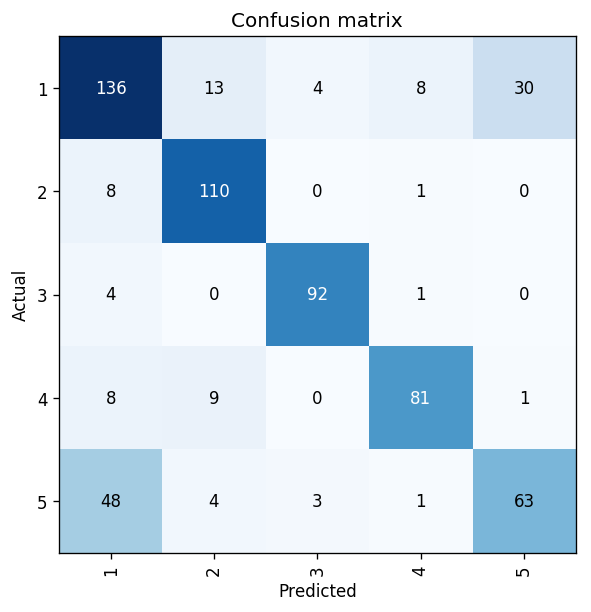

In [21]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=120)

In [22]:
learn.unfreeze()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


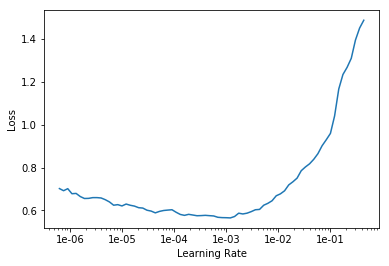

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, max_lr=1e-4)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.600374,0.554638,0.789557,0.780800,01:22
1,0.604369,0.546967,0.788647,0.766400,01:22
2,0.593878,0.539953,0.802769,0.785600,01:24
3,0.554872,0.538842,0.801556,0.782400,01:21
4,0.562778,0.527900,0.805276,0.788800,01:22


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


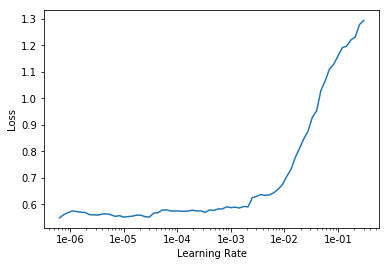

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-5
lrs=np.array([lr/10,lr/3,lr])
learn.unfreeze()
learn.fit(5,lr)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.556898,0.529652,0.806638,0.790400,01:22
1,0.568435,0.534236,0.806406,0.788800,01:23
2,0.564000,0.524451,0.804293,0.787200,01:21
3,0.549827,0.526477,0.806736,0.787200,01:22
4,0.558782,0.526486,0.799241,0.780800,01:23


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [27]:
train.shape

(6252, 2)

In [28]:
t  = pd.read_csv('../input/test_ApKoW4T.csv')
t.shape[0]

2680

In [29]:
data.add_test(items=[path/'images'/i for i in t['image'].tolist()],label=None)

In [30]:
data.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5812724ba8>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f58192630d0>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f58204a87b8>)

In [31]:
preds, y = learn.TTA(beta=0.4,ds_type=DatasetType.Test)

In [32]:
preds.shape

torch.Size([2680, 5])

In [33]:
imgName = t['image'].tolist()
imgName

['1007700.jpg',
 '1011369.jpg',
 '1051155.jpg',
 '1062001.jpg',
 '1069397.jpg',
 '1072861.jpg',
 '1097264.jpg',
 '1098763.jpg',
 '1098766.jpg',
 '1101145.jpg',
 '1114371.jpg',
 '1114781.jpg',
 '1115492.jpg',
 '1121306.jpg',
 '1123736.jpg',
 '1124946.jpg',
 '1125700.jpg',
 '1127236.jpg',
 '1127336.jpg',
 '1130300.jpg',
 '1131990.jpg',
 '1141996.jpg',
 '1145082.jpg',
 '1153400.jpg',
 '1162763.jpg',
 '1162764.jpg',
 '1162765.jpg',
 '1163874.jpg',
 '1174623.jpg',
 '1185778.jpg',
 '1186207.jpg',
 '1193420.jpg',
 '1203926.jpg',
 '1228622.jpg',
 '1229806.jpg',
 '1243717.jpg',
 '1244690.jpg',
 '1244768.jpg',
 '1250078.jpg',
 '1250085.jpg',
 '1252407.jpg',
 '1260394.jpg',
 '1263061.jpg',
 '1263459.jpg',
 '1289223.jpg',
 '1289225.jpg',
 '1296498.jpg',
 '1311396.jpg',
 '1314965.jpg',
 '1324036.jpg',
 '1334848.jpg',
 '1334855.jpg',
 '1342277.jpg',
 '1345016.jpg',
 '1352852.jpg',
 '1359851.jpg',
 '1368439.jpg',
 '1382476.jpg',
 '1386041.jpg',
 '1396598.jpg',
 '1400085.jpg',
 '1400092.jpg',
 '141293

In [34]:
preds_  = torch.argmax(preds,1)+1
preds_

tensor([1, 4, 4,  ..., 4, 2, 1])

In [35]:
preds_ = preds_.numpy()
preds_

array([1, 4, 4, 2, ..., 4, 4, 2, 1])

In [36]:
pd.Series(preds_).value_counts()

1    1021
2     540
3     410
5     388
4     321
dtype: int64

In [37]:
predsDF = pd.DataFrame()
predsDF['image'] = imgName
predsDF['category'] = preds_
predsDF.head(20)

,image,category
0,1007700.jpg,1
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
5,1072861.jpg,4
6,1097264.jpg,4
7,1098763.jpg,2
8,1098766.jpg,2
9,1101145.jpg,1


In [38]:
t.head(20)

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [39]:
sum(predsDF['image'] == t['image']) == t.shape[0]

True

In [40]:
predsDF.to_csv('preds_BAM_Resnet101.csv',index=False)
from IPython.display import FileLink, FileLinks
FileLink('preds_BAM_Resnet101.csv')

/kaggle/working/preds_BAM_Resnet101.csv